# V1 - More Accurate

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Set the paths to the main sky image and the directory containing constellation templates
sky_image_path = 'Temp/3LM.png'  # Replace with your actual sky image path
template_dir = '8CD'  # Folder containing subfolders with constellation templates

# Function to load image safely
def load_image(image_path):
    """Load an image from the given path and convert it to grayscale."""
    if not os.path.exists(image_path):
        print(f"Error: Image path does not exist: {image_path}")
        return None
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}. Please check the file path.")
    return image

# Function to preprocess the image (Histogram Equalization)
def preprocess_image(image):
    """Apply histogram equalization to improve image contrast."""
    if cv2.meanStdDev(image)[1] < 50:  # Check for low contrast before applying
        return cv2.equalizeHist(image)
    return image

# Function to display image in Jupyter
def display_image(image, title="Image"):
    """Display image using matplotlib."""
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to create a progress bar
def create_progress_bar(percentage, width=50):
    """Create a progress bar with specified width and percentage filled."""
    filled = int(width * percentage / 100) if percentage else 0
    return "█" * filled + "░" * (width - filled)

# Function to show the progress of template matching
def show_progress(current, total):
    """Display a progress bar for the template matching process."""
    percentage = (current / total) * 100
    progress_bar = create_progress_bar(percentage)
    print(f"Processing Templates: {percentage:5.1f}% {progress_bar} ({current}/{total})", end='\r')

# Initialize SIFT detector (more robust than ORB)
sift = cv2.SIFT_create(nfeatures=1000)  # Increase number of keypoints

# Load the sky image
sky_image = load_image(sky_image_path)

# Exit if sky image is not loaded correctly
if sky_image is None:
    print("Error loading sky image. Exiting.")
    exit()

# Preprocess sky image (apply histogram equalization)
sky_image = preprocess_image(sky_image)

# Get dimensions of the sky image
sky_height, sky_width = sky_image.shape

# Function to match keypoints between sky image and template
def match_keypoints(template, sky_image):
    """Match keypoints using SIFT and return good matches."""
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(sky_image, None)

    if des1 is None or des2 is None:
        return None, None, []

    # Use a FLANN-based matcher for feature matching
    index_params = dict(algorithm=1, trees=10)  # FLANN for SIFT
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test (Lowe's ratio test) to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]  # Ratio test

    # Apply Homography check (RANSAC) to remove false matches
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # Lower RANSAC threshold for better match acceptance
        matches_mask = mask.ravel().tolist()
        good_matches = [good_matches[i] for i in range(len(good_matches)) if matches_mask[i] == 1]

    return kp1, kp2, good_matches

# Function to resize template for multi-scale matching
def resize_template(template, scale_factor):
    """Resize template to different scales for better matching."""
    width = int(template.shape[1] * scale_factor)
    height = int(template.shape[0] * scale_factor)
    return cv2.resize(template, (width, height))

# Dictionary to store top matches
top_matches = []

# Get the total number of templates to process
total_templates = sum([len(files) for _, _, files in os.walk(template_dir)])

# Iterate over each constellation folder
current_template = 0
for constellation_folder in os.listdir(template_dir):
    constellation_path = os.path.join(template_dir, constellation_folder)
    
    if os.path.isdir(constellation_path):
        best_match_score_for_constellation = 0
        match_results = []

        # Iterate over each template image in the folder
        for template_file in os.listdir(constellation_path):
            if template_file.startswith('.'):
                continue
            
            template_path = os.path.join(constellation_path, template_file)
            template = load_image(template_path)
            
            if template is None:
                continue
            
            # Preprocess the template (apply histogram equalization)
            template = preprocess_image(template)

            # Resize template to different scales for better match (e.g., 50%, 100%, 150%)
            for scale in [0.5, 1.0, 1.5]:  # Example scales
                resized_template = resize_template(template, scale)
                kp1, kp2, good_matches = match_keypoints(resized_template, sky_image)
                
                # Only proceed if we have good matches
                if len(good_matches) > 10:  # Minimum number of good matches
                    match_results.append((resized_template, len(good_matches), constellation_folder, template_file, scale))
            
            # Update the progress bar after processing each template
            current_template += 1
            show_progress(current_template, total_templates)
        
        # Sort match results by number of good matches (descending)
        match_results.sort(key=lambda x: x[1], reverse=True)

        # Store the top 3 matches for each constellation
        top_matches.extend(match_results[:3])  # Get the top 3

# Sort all results by number of good matches
top_matches.sort(key=lambda x: x[1], reverse=True)

# Track added constellations to ensure one per rank
added_constellations = set()
top_3_matches = []

# Filter top 3 results to ensure one constellation per rank
for template, score, constellation, template_file, scale in top_matches:
    if constellation not in added_constellations:
        added_constellations.add(constellation)
        top_3_matches.append((template, score, constellation, template_file, scale))
    if len(top_3_matches) == 3:  # Only keep top 3 unique constellations
        break

# Display top 3 most probable matches with probability (percentage of good matches)
for i, (template, score, constellation, template_file, scale) in enumerate(top_3_matches):
    probability = (score / float(sky_height * sky_width)) * 100  # Normalize probability
    print(f"Rank {i+1}: {constellation} - Template: {template_file} (Scale: {scale}) - Probability: {probability:.2f}% with {score} matches.")

    # Draw bounding box around matched region
    kp1, kp2, good_matches = match_keypoints(template, sky_image)
    if good_matches:
        matched_image = cv2.drawMatches(template, kp1, sky_image, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        display_image(matched_image, f"Top Match: {constellation} - {template_file} (Scale: {scale})")

# If no good matches found
if not top_3_matches:
    print("No good matches found.")

# V2 - More Fast

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
import sys  # For flushing output

# Set the paths to the main sky image and the directory containing constellation templates
sky_image_path = 'Temp/1CB.png'  # Replace with your actual sky image path
template_dir = '8CD'  # Folder containing subfolders with constellation templates

# Lock for thread-safe progress updates
progress_lock = Lock()

# Function to load image safely
def load_image(image_path):
    """Load an image from the given path and convert it to grayscale."""
    if not os.path.exists(image_path):
        print(f"Error: Image path does not exist: {image_path}")
        return None
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}. Please check the file path.")
    return image

# Function to preprocess the image (Histogram Equalization)
def preprocess_image(image):
    """Apply histogram equalization to improve image contrast."""
    if cv2.meanStdDev(image)[1] < 50:  # Check for low contrast before applying
        return cv2.equalizeHist(image)
    return image

# Function to display image in Jupyter
def display_image(image, title="Image"):
    """Display image using matplotlib."""
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to create a progress bar
def create_progress_bar(percentage, width=50):
    """Create a progress bar with specified width and percentage filled."""
    filled = int(width * percentage / 100) if percentage else 0
    return "█" * filled + "░" * (width - filled)

# Function to show the progress of template matching
def show_progress(current, total):
    """Display a progress bar for the template matching process."""
    with progress_lock:
        percentage = (current / total) * 100
        progress_bar = create_progress_bar(percentage)
        print(f"Processing Templates: {percentage:5.1f}% {progress_bar} ({current}/{total})", end='\r')
        sys.stdout.flush()  # Force flush of output

# Initialize SIFT detector (more robust than ORB)
sift = cv2.SIFT_create(nfeatures=1000)  # Increase number of keypoints

# Load the sky image
sky_image = load_image(sky_image_path)

# Exit if sky image is not loaded correctly
if sky_image is None:
    print("Error loading sky image. Exiting.")
    exit()

# Preprocess sky image (apply histogram equalization)
sky_image = preprocess_image(sky_image)

# Get dimensions of the sky image
sky_height, sky_width = sky_image.shape

# Function to match keypoints between sky image and template
def match_keypoints(template, sky_image):
    """Match keypoints using SIFT and return good matches."""
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(sky_image, None)

    if des1 is None or des2 is None:
        return None, None, []

    # Check descriptor types and convert them to float32 if necessary
    if des1.dtype != np.float32:
        des1 = np.float32(des1)
    if des2.dtype != np.float32:
        des2 = np.float32(des2)

    # Use a FLANN-based matcher for feature matching
    index_params = dict(algorithm=1, trees=10)  # FLANN for SIFT
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test (Lowe's ratio test) to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]  # Ratio test

    # Apply Homography check (RANSAC) to remove false matches
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # Lower RANSAC threshold for better match acceptance
        matches_mask = mask.ravel().tolist()
        good_matches = [good_matches[i] for i in range(len(good_matches)) if matches_mask[i] == 1]

    return kp1, kp2, good_matches

# Function to resize template for multi-scale matching
def resize_template(template, scale_factor):
    """Resize template to different scales for better matching."""
    width = int(template.shape[1] * scale_factor)
    height = int(template.shape[0] * scale_factor)
    return cv2.resize(template, (width, height))

# Function to process each constellation folder
def process_constellation_folder(constellation_folder, total_templates):
    """Process each constellation folder to find the best matches."""
    match_results = []
    constellation_path = os.path.join(template_dir, constellation_folder)
    
    if os.path.isdir(constellation_path):
        total_files = len([f for f in os.listdir(constellation_path) if not f.startswith('.')])
        processed_files = 0
        
        # Iterate over each template image in the folder
        for template_file in os.listdir(constellation_path):
            if template_file.startswith('.'):
                continue
            
            template_path = os.path.join(constellation_path, template_file)
            template = load_image(template_path)
            
            if template is None:
                continue
            
            # Preprocess the template (apply histogram equalization)
            template = preprocess_image(template)

            # Resize template to different scales for better match (e.g., 50%, 100%, 150%)
            for scale in [1.0, 0.8, 1.2]:  # Example scales
                resized_template = resize_template(template, scale)
                kp1, kp2, good_matches = match_keypoints(resized_template, sky_image)
                
                # Only proceed if we have good matches
                if len(good_matches) > 10:  # Minimum number of good matches
                    match_results.append((resized_template, len(good_matches), constellation_folder, template_file, scale))

            # Update progress bar for each file processed
            processed_files += 1
            show_progress(processed_files, total_files)

        return match_results

    return []

# Dictionary to store top matches
top_matches = []

# Get the total number of templates to process
total_templates = sum([len(files) for _, _, files in os.walk(template_dir)])

# Use multithreading to speed up the processing
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_constellation_folder, constellation_folder, total_templates) 
               for constellation_folder in os.listdir(template_dir) if os.path.isdir(os.path.join(template_dir, constellation_folder))]
    
    # Collect results from futures
    for future in as_completed(futures):
        result = future.result()
        top_matches.extend(result)

# Sort all results by number of good matches
top_matches.sort(key=lambda x: x[1], reverse=True)

# Track added constellations to ensure one per rank
added_constellations = set()
top_3_matches = []

# Filter top 3 results to ensure one constellation per rank
for template, score, constellation, template_file, scale in top_matches:
    if constellation not in added_constellations:
        added_constellations.add(constellation)
        top_3_matches.append((template, score, constellation, template_file, scale))
    if len(top_3_matches) == 3:  # Only keep top 3 unique constellations
        break

# Display top 3 most probable matches with probability (percentage of good matches)
for i, (template, score, constellation, template_file, scale) in enumerate(top_3_matches):
    probability = (score / float(sky_height * sky_width)) * 100  # Normalize probability
    print(f"Rank {i+1}: {constellation} - Template: {template_file} (Scale: {scale}) - Probability: {probability:.2f}% with {score} matches.")

    # Draw bounding box around matched region on sky image
    kp1, kp2, good_matches = match_keypoints(template, sky_image)
    matched_image = cv2.drawMatches(template, kp1, sky_image, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display the result
    display_image(matched_image, f"Top Match {i+1}: {constellation} - {template_file} - Scale: {scale}")

# V3 - Optimized Hybrid

Processing Templates: 100.0% ██████████████████████████████████████████████████ (340/340)
Finished Processing

Rank 1: Pisces_augmented - Template: Pisces-SKYMAP_blur_ksize_11.png (Scale: 1.0) - Probability: 0.06% with 408 matches.


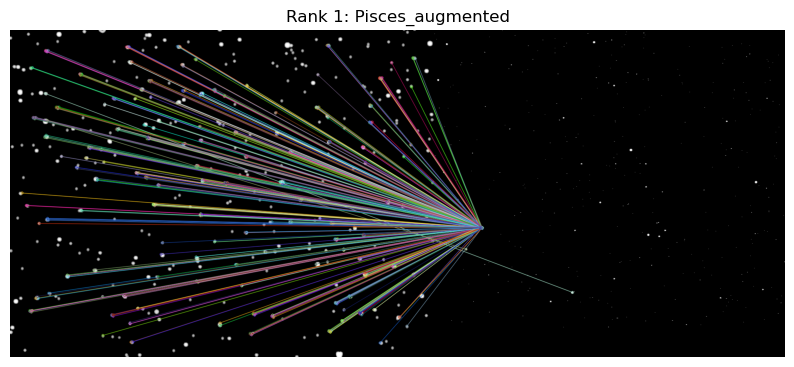

Rank 2: LeoMinor_augmented - Template: LeoMinor-SKYMAP_blur_ksize_11.png (Scale: 1.0) - Probability: 0.05% with 326 matches.


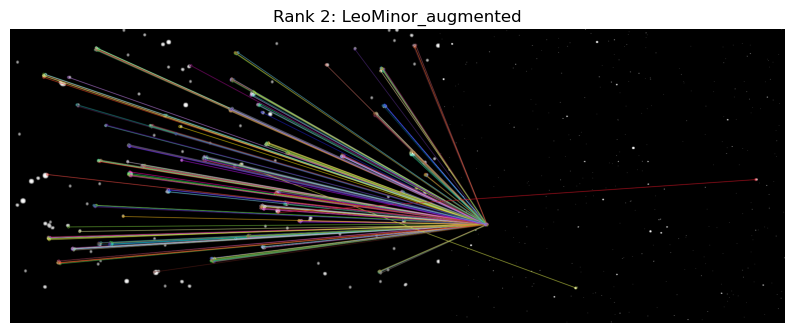

Rank 3: CoronaBorealis_augmented - Template: CoronaBorealis-LightSky_blur_ksize_9.png (Scale: 1.2) - Probability: 0.05% with 321 matches.


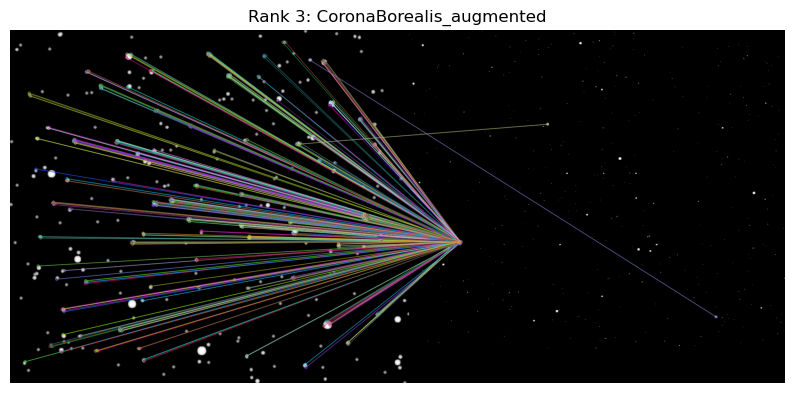

In [32]:
import cv2 # For image processing
import os # For file operations
import numpy as np # For numerical operations
import matplotlib.pyplot as plt # For plotting images
from concurrent.futures import ThreadPoolExecutor, as_completed # For parallel processing
import sys # For flushing output
import threading # For thread synchronization

# Set the paths to the main sky image and the directory containing constellation templates
sky_image_path = 'Temp/3LM.png'  # Replace with your actual sky image path
template_dir = '8CD'  # Folder containing subfolders with constellation templates

# Function to load image safely
def load_image(image_path):
    """Load an image from the given path and convert it to grayscale."""
    if not os.path.exists(image_path):
        print(f"Error: Image path does not exist: {image_path}")
        return None
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}. Please check the file path.")
    return image

# Function to preprocess the image (Histogram Equalization)
def preprocess_image(image):
    """Apply histogram equalization to improve image contrast."""
    if cv2.meanStdDev(image)[1] < 50:  # Check for low contrast before applying
        return cv2.equalizeHist(image)
    return image

# Function to display image in Jupyter
def display_image(image, title="Image"):
    """Display image using matplotlib."""
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to create a progress bar
def create_progress_bar(percentage, width=50):
    """Create a progress bar with specified width and percentage filled."""
    filled = int(width * percentage / 100) if percentage else 0
    return "█" * filled + "░" * (width - filled)

# Create a lock for synchronizing the progress bar output
progress_lock = threading.Lock()

# Function to show the progress of template matching with a lock
def show_progress(current, total):
    """Display a progress bar for the template matching process."""
    percentage = (current / total) * 100
    progress_bar = create_progress_bar(percentage)

    # Acquire the lock before printing the progress bar
    with progress_lock:
        sys.stdout.write("\r")  # Clear the current line
        sys.stdout.write(f"Processing Templates: {percentage:5.1f}% {progress_bar} ({current}/{total})")
        sys.stdout.flush()  # Force flush of output
        
# Load the sky image
sky_image = load_image(sky_image_path)

# Exit if sky image is not loaded correctly
if sky_image is None:
    print("Error loading sky image. Exiting.")
    exit()

# Preprocess sky image (apply histogram equalization)
sky_image = preprocess_image(sky_image)

# Get dimensions of the sky image
sky_height, sky_width = sky_image.shape

# Initialize ORB detector (more robust than SIFT for accuracy)
orb = cv2.ORB_create(nfeatures=2000)  # Increase the number of keypoints for more robust matches

# Function to match keypoints between sky image and template
def match_keypoints(template, sky_image):
    """Match keypoints using ORB and return good matches."""
    kp1, des1 = orb.detectAndCompute(template, None)
    kp2, des2 = orb.detectAndCompute(sky_image, None)

    if des1 is None or des2 is None:
        return None, None, []

    # Convert descriptors to float32 if necessary
    if des1.dtype != np.float32:
        des1 = des1.astype(np.float32)
    if des2.dtype != np.float32:
        des2 = des2.astype(np.float32)

    # Use a FLANN-based matcher for feature matching
    index_params = dict(algorithm=1, trees=10)  # FLANN for ORB
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test (Lowe's ratio test) to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]  # Ratio test

    # Apply Homography check (RANSAC) to remove false matches
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # Use a lower RANSAC threshold
        matches_mask = mask.ravel().tolist()
        good_matches = [good_matches[i] for i in range(len(good_matches)) if matches_mask[i] == 1]

    return kp1, kp2, good_matches

# Function to resize template for multi-scale matching
def resize_template(template, scale_factor):
    """Resize template to different scales for better matching."""
    width = int(template.shape[1] * scale_factor)
    height = int(template.shape[0] * scale_factor)
    return cv2.resize(template, (width, height))

# Function to process each constellation folder
def process_constellation_folder(constellation_folder, total_templates):
    """Process each constellation folder to find the best matches."""
    match_results = []
    constellation_path = os.path.join(template_dir, constellation_folder)
    
    if os.path.isdir(constellation_path):
        total_files = len([f for f in os.listdir(constellation_path) if not f.startswith('.')])
        processed_files = 0
        
        # Iterate over each template image in the folder
        for template_file in os.listdir(constellation_path):
            if template_file.startswith('.'):
                continue
            
            template_path = os.path.join(constellation_path, template_file)
            template = load_image(template_path)
            
            if template is None:
                continue
            
            # Preprocess the template (apply histogram equalization)
            template = preprocess_image(template)

            # Resize template to different scales for better match (e.g., 50%, 100%, 150%)
            for scale in [1.0, 0.8, 1.2]:  # Example scales
                resized_template = resize_template(template, scale)
                kp1, kp2, good_matches = match_keypoints(resized_template, sky_image)
                
                # Only proceed if we have good matches
                if len(good_matches) > 10:  # Minimum number of good matches
                    match_results.append((resized_template, len(good_matches), constellation_folder, template_file, scale))

            # Update progress bar for each file processed
            processed_files += 1
            show_progress(processed_files, total_files)

        return match_results

    return []

# Dictionary to store top matches
top_matches = []

# Get the total number of templates to process
total_templates = sum([len(files) for _, _, files in os.walk(template_dir)])

# Use multithreading to speed up the processing
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_constellation_folder, constellation_folder, total_templates) 
               for constellation_folder in os.listdir(template_dir) if os.path.isdir(os.path.join(template_dir, constellation_folder))]
    
    # Collect results from futures
    for future in as_completed(futures):
        result = future.result()
        top_matches.extend(result)

# Sort all results by number of good matches
top_matches.sort(key=lambda x: x[1], reverse=True)

# Track added constellations to ensure one per rank
added_constellations = set()
top_3_matches = []

# Filter top 3 results to ensure one constellation per rank
for template, score, constellation, template_file, scale in top_matches:
    if constellation not in added_constellations:
        added_constellations.add(constellation)
        top_3_matches.append((template, score, constellation, template_file, scale))
    if len(top_3_matches) == 3:  # Only keep top 3 unique constellations
        break

# Display top 3 most probable matches with probability (percentage of good matches)
print("\n\033[1mFinished Processing\033[0m\n")
for i, (template, score, constellation, template_file, scale) in enumerate(top_3_matches):
    probability = (score / float(sky_height * sky_width)) * 100  # Normalize probability
    print(f"Rank {i+1}: {constellation} - Template: {template_file} (Scale: {scale}) - Probability: {probability:.2f}% with {score} matches.")

    # Draw bounding box around matched region on sky image
    kp1, kp2, good_matches = match_keypoints(template, sky_image)
    matched_image = cv2.drawMatches(template, kp1, sky_image, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    display_image(matched_image, title=f"Rank {i+1}: {constellation}")
